#  Viridisify

How to remap a plot which has a non perceptually uniform colormap with encoding artifacts ? As asked by @stefanv:

https://twitter.com/stefanvdwalt/status/784429257556492288

This assume that you "know" the initial color map of a plot, and that the emcoding/compressing process of the plot will not change the colors "too much". This will try to remap all the pixels that fall not "too far" from the initial colormap to the new colormap. 

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib.colors as colors

In [3]:
cd ~/Desktop/vir/

/Users/bussonniermatthias/Desktop/vir


In [4]:
!rm *.png *.gif out*

rm: output.gif: No such file or directory


I used the following to convert from mp4 to image sequence (8 fps determined manually). 
Sequence of images to video, and video to gif (quality is better than to gif dirrectly):

```
$ ffmpeg -i INPUT.mp4 -r 8 -f image2 img%02d.png
$ ffmpeg -framerate 8 -i vir-img%02d.png -c:v libx264 -r 8 -pix_fmt yuv420p out.mp4
$ ffmpeg -i out.mp4  output.gif
```

In [5]:
%%bash
ffmpeg -i input.mp4 -r 8 -f image2 img%02d.png -loglevel panic

Let's take our image without the alpha channel, so only the first 3 components:

In [6]:
import matplotlib.image as mpimg
img = mpimg.imread('img01.png')[:,:,:3]

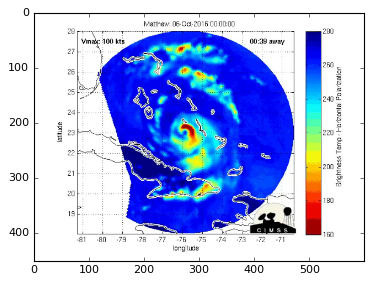

In [7]:
plt.imshow(img)

As you can see it does use "Jet" (most likely), in order to find all the pixels that uses "Jet" efficiently we will use `scipy.spatial.KDTree` in the colorspace. In particular we will subsample the initial colormap in `sub=256` subsamples, and collect only pixels that are within `d=0.2` of this subsample, and map each of these pixels to the closer subsample. 

As we know the subsampling of the initial colormap, we can also determine the output colors. 

The Pixels that are "too far" from the pixels of the colormap are keep unchanged. 

increasing 256 to higher value will give a smoother final colormap. 

In [8]:
from scipy.spatial import cKDTree

In [9]:
def convert(sub=256, d=0.2, cin='jet', cout='viridis', img=img, show=True):
    viridis = plt.get_cmap(cout)
    cmapin = plt.get_cmap(cin)
    cmap256 = colors.makeMappingArray(sub, cmapin)[:, :3]
    K = cKDTree(cmap256)
    original_shape = img.shape
    img_data = img.reshape((-1,3))
    res = K.query(img_data, distance_upper_bound=d)
    indices = res[1]
    l = len(cmap256)
    indices = indices.reshape(original_shape[:2])
    remapped = indices

    indices.max()

    mask = (indices == l)

    remapped = remapped / (l-1)
    mask = np.stack( [mask]*3, axis=-1)

    blend = np.where(mask, img, viridis(remapped)[:,:,:3])
    if show:
        fig, ax = plt.subplots()
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.imshow(blend)
    return blend

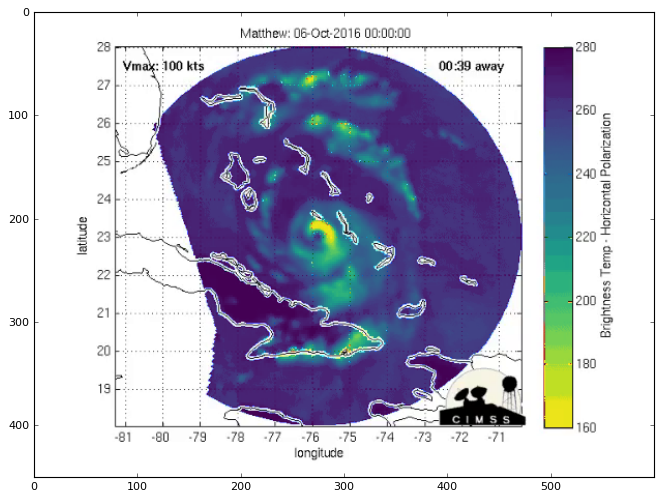

In [10]:
tpl = 'img%02d.png'
tplv = 'vir-img%02d.png'
for i in range(1,18):
    img = mpimg.imread(tpl%i)[:,:,:3]
    vimg = convert(show=(i==1), img=img)
    mpimg.imsave(tplv %i, vimg)

In [11]:
%%bash
ffmpeg -framerate 8 -i vir-img%02d.png -c:v libx264 -r 8 -pix_fmt yuv420p out.mp4 -y -loglevel panic

In [12]:
%%bash
ffmpeg -i out.mp4  output.gif -y -loglevel panic

In [13]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt

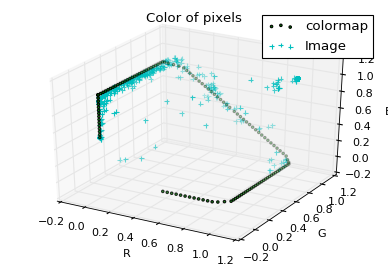

In [14]:
def rep(im, cin='jet', sub=128):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    pp = im.reshape((-1,3)).T[:,::300]
    
    
    cmapin = plt.get_cmap(cin)
    cmap256 = colors.makeMappingArray(sub, cmapin)[:, :3].T
    ax.scatter(cmap256[0], cmap256[1], cmap256[2], c='g', marker='.', label='colormap')
    
    ax.scatter(pp[0], pp[1], pp[2], c='c', marker='+', label='Image')
    
    ax.set_xlabel('R')
    ax.set_ylabel('G')
    ax.set_zlabel('B')
    ax.set_title('Color of pixels')
    ax.legend()
    
rep(img)

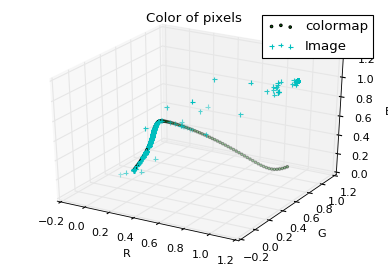

In [16]:
rep(vimg,'viridis')